In [1]:
import torch
import torch.optim as optim
from torch_geometric.data import InMemoryDataset
from dataset import load_split
import pandas as pd
from torch_geometric.nn import TransE
from torch_geometric.nn.kge.loader import KGTripletLoader
from dataset import PygLncTarD
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"; "using " + device

'using cuda'

In [4]:
train_data, val_data, test_data = (
  PygLncTarD("train", device=device),
  PygLncTarD("val", device=device),
  PygLncTarD("test", device=device),
)

cannot load 18/5437 tuple(s) from train because of weird string encoding
cannot load 1/678 tuple(s) from val because of weird string encoding
cannot load 2/679 tuple(s) from test because of weird string encoding


In [14]:
model = TransE(
  num_nodes=train_data.num_nodes,
  num_relations=train_data.num_edge_types,
  hidden_channels=200,
).to(device)

In [15]:
model

TransE(3367, num_relations=7, hidden_channels=200)

In [16]:
optimizer = optim.Adam(model.parameters(), lr=.01)

In [17]:
loader = KGTripletLoader(
  *train_data.tuples.T, batch_size=2 ** 16, shuffle=True,
)

In [18]:
def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

@torch.no_grad()
def test(data):
    model.eval()
    loss = model.loss(data.edge_index[0], data.edge_type, data.edge_index[1])
    return (loss,) + model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=1000,
        k=10,
        log=False,
    )

In [19]:
tr_lossx,tr_lossy,val_lossx,val_lossy = [],[],[],[]

In [20]:
vloss = None
for epoch in (pbar := trange(1, 501)):
    loss = train()
    tr_lossx.append(epoch)
    tr_lossy.append(loss)
    if epoch % 25 == 0:
        vloss, rank, hits = test(val_data)
        #pbar.write(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        #           f'Val Hits@10: {hits:.4f}')
        val_lossx.append(epoch)
        val_lossy.append(vloss.item())
    if vloss is not None:
      pbar.set_description(f"tl:%.03f,vl:%.03f" % (loss,vloss.item()))
    else:
      pbar.set_description(f"tl:%.03f" % loss)

tl:0.134,vl:0.519: 100%|██████████████████████| 500/500 [00:13<00:00, 36.43it/s]


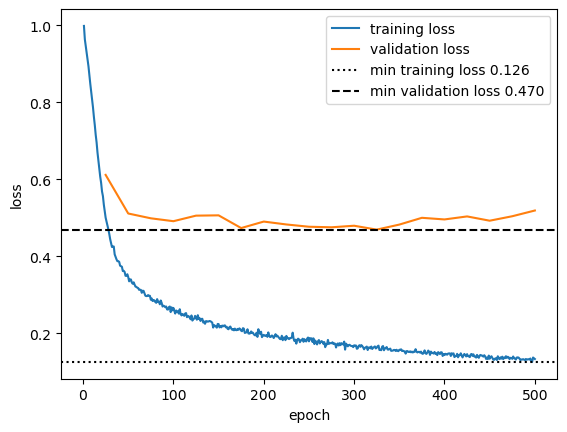

In [23]:
plt.plot(tr_lossx,tr_lossy, label="training loss")
plt.plot(val_lossx,val_lossy, label="validation loss")
plt.axhline(y=min(tr_lossy), linestyle=":", color="k", label="min training loss %.03f" % min(tr_lossy))
plt.axhline(y=min(val_lossy), linestyle="--", color="k", label="min validation loss %.03f" % min(val_lossy))
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend();